# Examine crop/not crop pixel populations

**What does this notebook do?**


**Required inputs**

**Date** July 2018

**Author** Claire Krause

In [20]:
%pylab notebook

import xarray as xr
import geopandas as gp
import rasterio.features
from affine import Affine
from osgeo import gdal

Populating the interactive namespace from numpy and matplotlib


## Set up the notebook

In [2]:
WoodyFile = '/g/data/r78/cek156/datacube_stats/Woody/summer/woody_20121101.nc'

ValidationFile = '/g/data/r78/cek156/NSWDOI_IrrigatedCropExtents/CropArea_Namoi_Landsat2013_Jan_Mar_withLanduse.shp'

## Load in the data

In [3]:
# Open the NetCDF dataset
Woody = xr.open_dataset(WoodyFile)

In [10]:
ValidationShapes = gp.read_file(ValidationFile)
ValidationShapes = ValidationShapes.to_crs(epsg = 3577)

I am densified (external_values, 1220 elements)


### Generate affine for the Woody dataset

This is a super hacky solution, but will do for now. We need to re-open just one band of the netCDF file with the `xr.open_rasterio` function so that we can steal the `transform` object that is created. Since we just want an `affine` object, we can just use the `transform` minus the last three numbers.

In [30]:
WoodyAffine = xr.open_rasterio('netcdf:{}:smad'.format(WoodyFile))

## Create a mask from the validation shapefile

In [63]:
ValidationMask = rasterio.features.rasterize(((feature['geometry'], 1)
                                              for feature in ValidationShapes.iterfeatures()),
                                             out_shape=Woody.smad.squeeze().shape,
                                             transform=WoodyAffine.transform[:-3])
ValidationMask = ValidationMask.astype(float)
ValidationMask[ValidationMask == 0] = np.nan

## Apply the validation mask and use it to examine the resulting pixel populations

In [74]:
## SMAD
# Data * mask = data or nan
SMADMaskCrop = ValidationMask * Woody.smad
# Find where the mask is nan, and use this True/False to mask data
SMADMaskNoCrop = Woody.smad.where(np.isnan(ValidationMask))

## Bare
# Data * mask = data or nan
BareMaskCrop = ValidationMask * Woody.bare
# Find where the mask is nan, and use this True/False to mask data
BareMaskNoCrop = Woody.bare.where(np.isnan(ValidationMask))

## Veg
# Data * mask = data or nan
VegMaskCrop = ValidationMask * Woody.veg
# Find where the mask is nan, and use this True/False to mask data
VegMaskNoCrop = Woody.veg.where(np.isnan(ValidationMask))

## Need to flatten the data so we can plot two single dimension arrays against each other

In [75]:
SMADMaskCropFlat = SMADMaskCrop.data.reshape(SMADMaskCrop.x.size * SMADMaskCrop.y.size)
SMADMaskNoCropFlat = SMADMaskNoCrop.data.reshape(SMADMaskNoCrop.x.size * SMADMaskNoCrop.y.size)

BareMaskCropFlat = BareMaskCrop.data.reshape(BareMaskCrop.x.size * BareMaskCrop.y.size)
BareMaskNoCropFlat = BareMaskNoCrop.data.reshape(BareMaskNoCrop.x.size * BareMaskNoCrop.y.size)

VegMaskCropFlat = VegMaskCrop.data.reshape(VegMaskCrop.x.size * VegMaskCrop.y.size)
VegMaskNoCropFlat = VegMaskNoCrop.data.reshape(VegMaskNoCrop.x.size * VegMaskNoCrop.y.size)

## Draw a histogram of the two populations

Matplotlib histogram doesn't like `nan`, so we need to remove the `nan` values before we can create a histogram. This is done by reshaping the array into a single dimension, then removing the nan values.

This histogram will allow us to determine a valid threshold value for the automatic irrigated crop extent layer.

<IPython.core.display.Javascript object>


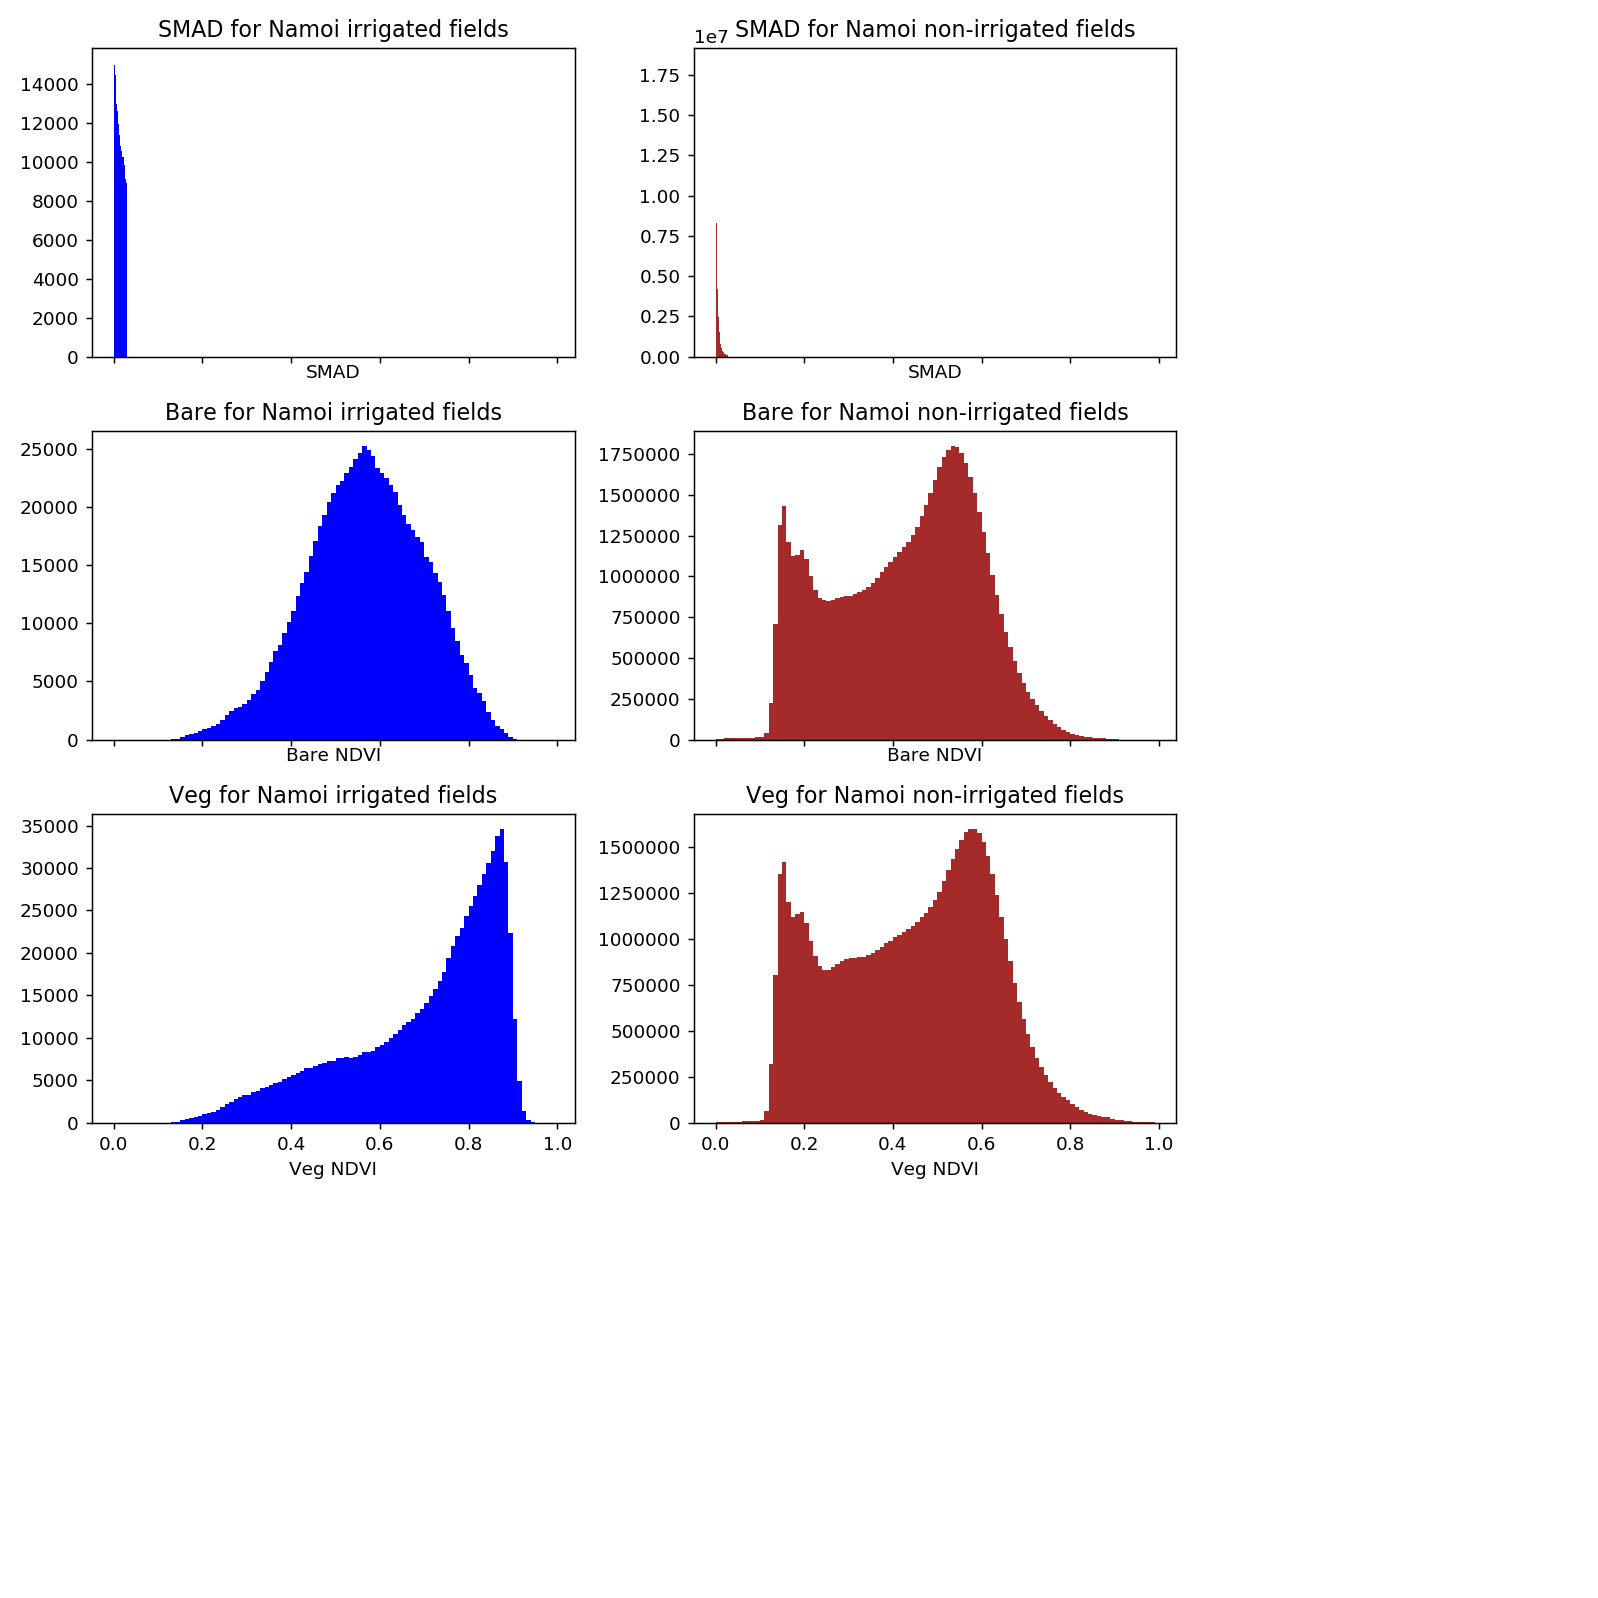

Text(0.5,0,'Veg NDVI')

In [82]:
bin_values = np.arange(0, 0.03, 0.001)
bin_valuesNDVI = np.arange(0, 1, 0.01)

fig, axs = plt.subplots(3, 2, sharex=True, tight_layout=True, figsize = [9,9])
axs[0][0].hist(SMADMaskCropFlat[np.isfinite(SMADMaskCropFlat)], bins=bin_values, facecolor = 'blue');
axs[0][0].set_title('SMAD for Namoi irrigated fields')
axs[0][0].set_xlabel('SMAD')
axs[0][1].hist(SMADMaskNoCropFlat[np.isfinite(SMADMaskNoCropFlat)], bins=bin_values, facecolor = 'brown');
axs[0][1].set_title('SMAD for Namoi non-irrigated fields')
axs[0][1].set_xlabel('SMAD')

axs[1][0].hist(BareMaskCropFlat[np.isfinite(BareMaskCropFlat)], bins=bin_valuesNDVI, facecolor = 'blue');
axs[1][0].set_title('Bare for Namoi irrigated fields')
axs[1][0].set_xlabel('Bare NDVI')
axs[1][1].hist(BareMaskNoCropFlat[np.isfinite(BareMaskNoCropFlat)], bins=bin_valuesNDVI, facecolor = 'brown');
axs[1][1].set_title('Bare for Namoi non-irrigated fields')
axs[1][1].set_xlabel('Bare NDVI')

axs[2][0].hist(VegMaskCropFlat[np.isfinite(VegMaskCropFlat)], bins=bin_valuesNDVI, facecolor = 'blue');
axs[2][0].set_title('Veg for Namoi irrigated fields')
axs[2][0].set_xlabel('Veg NDVI')
axs[2][1].hist(VegMaskNoCropFlat[np.isfinite(VegMaskNoCropFlat)], bins=bin_valuesNDVI, facecolor = 'brown');
axs[2][1].set_title('Veg for Namoi non-irrigated fields')
axs[2][1].set_xlabel('Veg NDVI')


#savefig('/g/data/r78/cek156/dea-notebooks/Crop_mapping/Playing_around/Namoi_NDVI_{1}.jpg'.format(Index, year))

In [81]:
axs[0][0]

## Is there a relationship between a pixel's NDVI and NDMI?

<IPython.core.display.Javascript object>


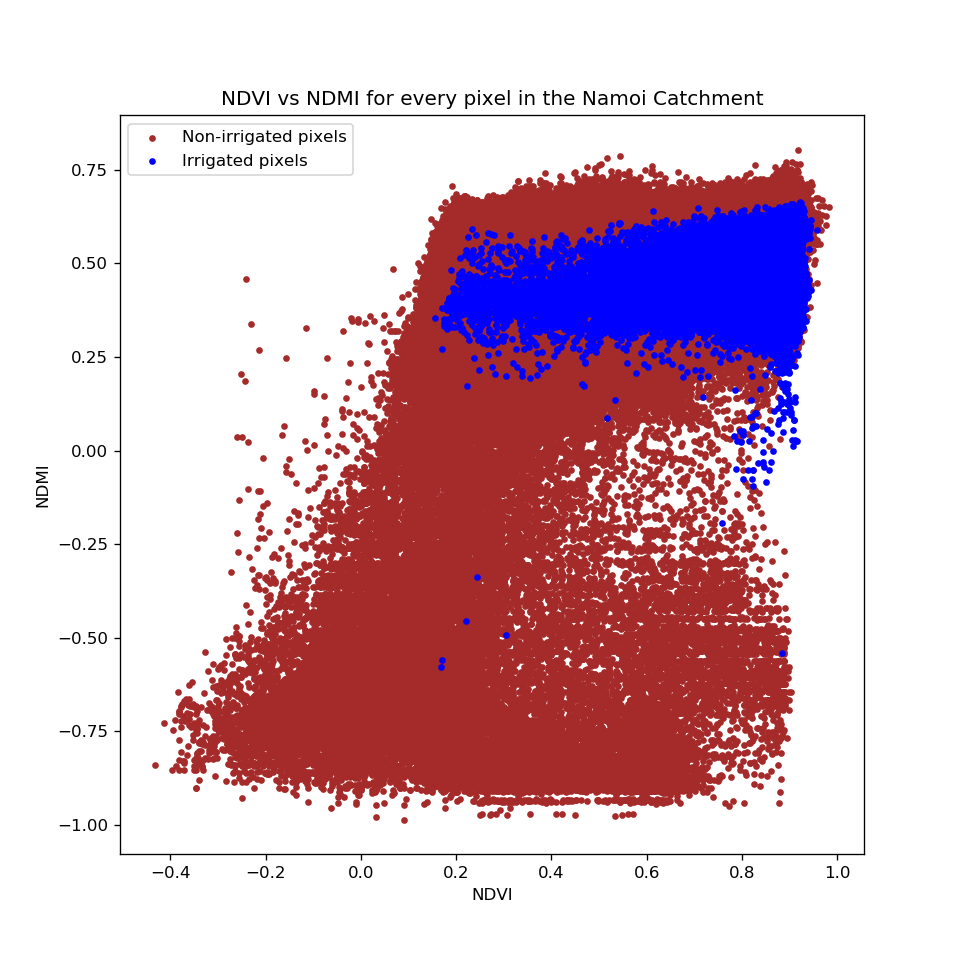

In [12]:
plt.figure(figsize = [8,8])

plt.scatter(NDVINonIrrigatedflat[::10], NDMINonIrrigatedflat[::10], facecolor = 'brown', marker = '.')
plt.scatter(NDVIIrrigatedflat[::10], NDMIIrrigatedflat[::10], facecolor = 'blue', marker = '.')
plt.xlabel('NDVI')
plt.ylabel('NDMI')
plt.title('NDVI vs NDMI for every pixel in the Namoi Catchment')
plt.legend(['Non-irrigated pixels', 'Irrigated pixels'])
savefig('/g/data/r78/cek156/dea-notebooks/Crop_mapping/Playing_around/Namoi_scatter_{0}.jpg'.format(year))